# **CNN assignment**(Do read the note at the end)

Description: Here we are going to use CNN to classify images of elephants,tigers,cheetah's and crocodiles. Basically multiclass classificiation using CNN.

In [ ]:
# pip install tensorflow[and-cuda] #in case of warnings during training

**Q.1** Import all required modules

In [1]:
from keras.models import Sequential                         
from keras.layers import Conv2D                            
from keras.layers import MaxPooling2D                    
from keras.layers import Flatten                          
from keras.layers import Dense                               
from keras.layers import Dropout                             
from keras.layers import BatchNormalization                  
from keras.layers import Activation                          
from keras.callbacks import EarlyStopping, ModelCheckpoint  
from keras.models import load_model                         
# Preprocessing layers
from keras.layers import Rescaling                          

# Importing TensorFlow
import tensorflow as tf

import keras
import matplotlib.pyplot as plt

seed=42
dir_path='/kaggle/input/cnn-data/data/'

2024-07-21 07:07:42.981238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 07:07:42.981344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 07:07:43.115882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Q.2** Load data using image_dataset_from_directory(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [2]:
data = tf.keras.utils.image_dataset_from_directory(
    dir_path,                    # Directory where the Training images are located
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Cheetah', 'Crocodile', 'Elephants','Tiger'],
    batch_size = 16,   
    image_size = (256, 256),
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True  # Resize images without aspect ratio distortion
)

Found 1658 files belonging to 4 classes.




*   Since data object is not iterable,we will create a nummpy iterator for data.
*   Then use batch to iterate through our data



In [3]:
data_iterator=data.as_numpy_iterator()

In [10]:
batch=data_iterator.next()

Each batch of images has 16 images and labels(one-hot-encoded).

- len(batch)=2
- batch[0] conatains 16 images
- batch[1] contains 16 labels

Run the below code and batch code 2-3 times to visualise the labels given to different animals.

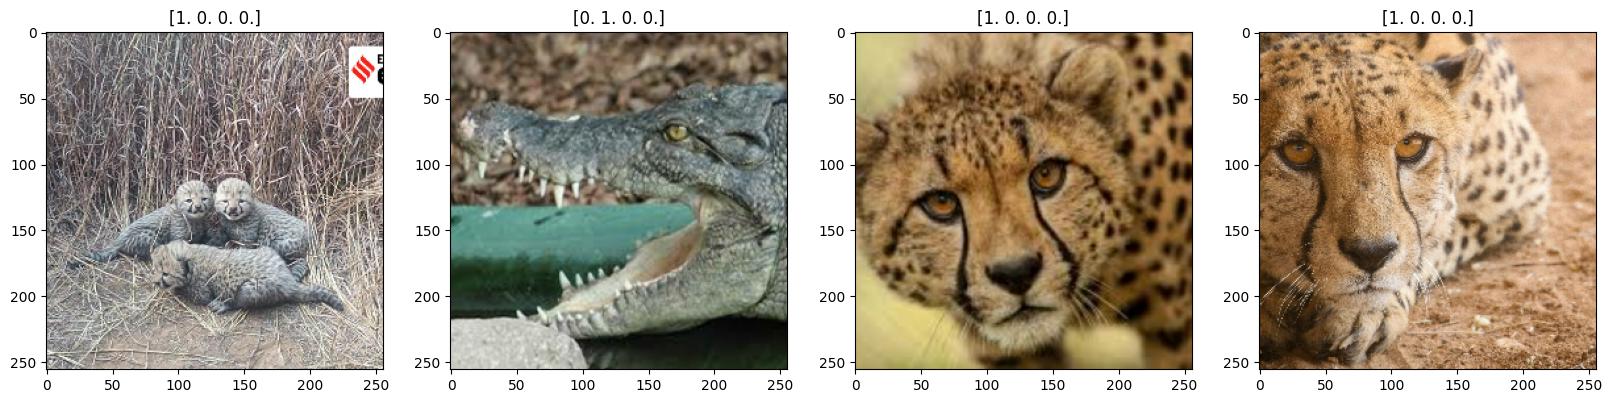

In [16]:
fig,axis=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  axis[idx].imshow(img.astype(int))
  axis[idx].title.set_text(str(batch[1][idx]))

**Q.3** Map the data such that all pixel values lie between 0 and 1 using the **lambda function**

In [20]:
scaler = Rescaling(1./255)
data=data.map(lambda x, y: (scaler(x), y))

**Q.4** Split the data into train set and test set(and validation set if needed) using **data.take**(https://www.geeksforgeeks.org/tensorflow-js-tf-data-dataset-class-take-method/) and **data.skip**(https://www.geeksforgeeks.org/tensorflow-js-tf-data-dataset-skip-method/)

In [21]:
total_batches = tf.data.experimental.cardinality(data).numpy()
train_batches=round(0.9*total_batches)
test_batches=total_batches-train_batches

train_data=data.take(train_batches) #Note:.take() & .skip() takes batches as arguments instead of images number
test_data=data.skip(train_batches)

**Creating the model**

**Q.5** Write code to create CNN model including fully connected layers with softmax as final layer.

In [58]:
model=Sequential()

# Input Layer
model.add(keras.Input(shape=(256, 256, 3)))

#Convolution Layers
model.add(Conv2D(32,(3,3),strides=1,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),strides=1,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(5,5),strides=1,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(256,(5,5),strides=1,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.4))

# model.add(Conv2D(512,(3,3),strides=1,padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
# model.add(Dropout(0.3))

# Flattening
model.add(Flatten())

# Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(4, activation = 'softmax'))

**Q.6** Compile your model

In [59]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) 

In [60]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath='/kaggle/working/best_model.keras',
                            save_best_only = True)

**Q.7** Fit your model with train set and make sure to keep **less epochs**(10-15) as the dataset size is very large.

In [61]:
model.fit(train_data,
          epochs=18,
          callbacks = [early_stopping, checkpoint]
          )

Epoch 1/18
 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2412 - loss: 19.3169

W0000 00:00:1721547479.957794     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.3431 - loss: 9.7144
Epoch 2/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4437 - loss: 2.3676
Epoch 3/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4572 - loss: 1.6376
Epoch 4/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5060 - loss: 1.3924
Epoch 5/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5825 - loss: 1.3007
Epoch 6/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6076 - loss: 1.0585
Epoch 7/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6853 - loss: 1.0356
Epoch 8/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7239 - loss: 0.8369
Epoch 9/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7615 - loss: 0.7064
Epoch 10/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7972 - loss: 0.6117
Epoch 11/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8582 - loss: 0.4476
Epoch 12/18
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8758 - 

**Q.8** Test your code with test set

In [62]:
loss,accuracy=model.evaluate(test_data)

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8992 - loss: 1.4119

W0000 00:00:1721547566.117435     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8986 - loss: 1.3745


W0000 00:00:1721547566.585235     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [63]:
# Do not change this code
if accuracy>=0.85:
  print(f"Congratulations, CNN assignment complete!! Your accuracy is {accuracy}")
else:
  print(f"Try again, not enough accuracy! Your accuracy is {accuracy}" )

Congratulations, CNN assignment complete!! Your accuracy is 0.8961039185523987


**Note: 1. Many of you will get very high train accuracy but low test accuracy. This is called overfitting, this can be solved by increasing the train set size. If your getting low accuracy for both train and test, modify your layers in the model.**

**2.Do use T4GPU.Ideally your first epoch will take quite sometime and rest of the epochs will be faster but if all your epochs are taking a lot of time, try starting a new gpu session(open a new gmail account and open colab on that) because your free gpu might have exhausted itself.**

**3.Other than that everything should be fine, happy learning!!**